In [2]:
#Load the necessary libraries and modules
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier

In [3]:
# read the CVS file
df = pd.read_csv('CreditScoring.csv')

# data cleaning
df.columns = df.columns.str.lower()

status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'parttime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [4]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

df.status.value_counts()

df = df[df.status != 'unk']

In [5]:
#training 

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)

df_train, df_val = train_test_split(df_train_full, test_size=0.25,random_state=11)

y_train = (df_train.status == 'default').values
y_val = (df_val.status == 'default').values

del df_train['status']
del df_val['status']

df_train = df_train.fillna(0)
df_val = df_val.fillna(0)

dict_train = df_train.to_dict(orient = 'records')
dict_val = df_val.to_dict(orient = 'records')

In [6]:
#first record in dict_train 
{'seniority': 10,
'home': 'owner',
'time': 36,
'age': 36,
'marital': 'married',
'records': 'no',
'job': 'freelance',
'expenses': 75,
'income': 0.0,
'assets': 10000.0,
'debt': 0.0,
'amount': 1000,
'price': 1400}

dv = DictVectorizer(sparse =False)

X_train = dv.fit_transform(dict_train)

X_val = dv.transform(dict_val)

In [7]:
#decision tree classifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_train)[:,1]

roc_auc_score(y_train, y_pred) #overfitting = model cannot generalize

1.0

In [8]:
#check with validation

y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

#force to model to be simplier = restrict the size of tree 

dt = DecisionTreeClassifier(max_depth = 2)
dt.fit(X_train, y_train)

tree_text = export_text(dt, feature_names = dv.feature_names_)
print(tree_text)

y_pred = dt.predict_proba(X_train)[:,1]
auc = roc_auc_score(y_train, y_pred)
print('trained auc', auc)

y_pred = dt.predict_proba(X_val)[:,1]
auc = roc_auc_score(y_val, y_pred)
print('validation auc', auc)

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: True
|   |--- seniority >  6.50
|   |   |--- class: False
|--- records=no >  0.50
|   |--- job=parttime <= 0.50
|   |   |--- class: False
|   |--- job=parttime >  0.50
|   |   |--- class: True

trained auc 0.7054989859726213
validation auc 0.6685264343319367


In [9]:
#parameter tuning

for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth = depth)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    print('%4s ->  %.3f' % (depth, auc))

# max_depth = 5 gives the highest AUC , then 4 and 6 give good results
r_list = []
for m in [4,5,6]:
    print('depth: %s' % m)

    for s in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth = m, min_samples_leaf = s)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        r = r_list.append(auc)
        print('%s -> %.3f' % (s, auc))
    print()

   1 ->  0.606
   2 ->  0.669
   3 ->  0.739
   4 ->  0.761
   5 ->  0.766
   6 ->  0.749
  10 ->  0.686
  15 ->  0.679
  20 ->  0.659
None ->  0.650
depth: 4
1 -> 0.761
5 -> 0.761
10 -> 0.761
15 -> 0.764
20 -> 0.761
50 -> 0.753
100 -> 0.756
200 -> 0.747

depth: 5
1 -> 0.767
5 -> 0.768
10 -> 0.762
15 -> 0.773
20 -> 0.774
50 -> 0.767
100 -> 0.763
200 -> 0.759

depth: 6
1 -> 0.762
5 -> 0.760
10 -> 0.778
15 -> 0.785
20 -> 0.773
50 -> 0.772
100 -> 0.776
200 -> 0.768



In [10]:
#optimized parameters 

dt = DecisionTreeClassifier(max_depth = 6, min_samples_leaf = 15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

10 -> 0.781
20 -> 0.801
30 -> 0.813
40 -> 0.815
50 -> 0.816
60 -> 0.817
70 -> 0.818
80 -> 0.818
90 -> 0.820
100 -> 0.819
110 -> 0.819
120 -> 0.821
130 -> 0.822
140 -> 0.822
150 -> 0.820
160 -> 0.820
170 -> 0.819
180 -> 0.820
190 -> 0.820
200 -> 0.820


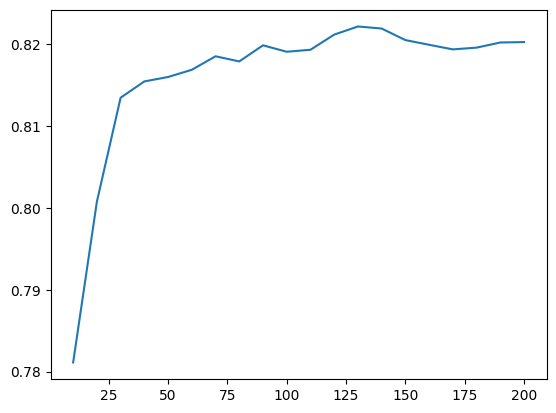

In [11]:
#random forest

rf = RandomForestClassifier(n_estimators = 10, random_state = 3) #number of trees
rf.fit(X_train, y_train)

y_pred =  rf.predict_proba(X_val)[0:,1]
roc_auc_score(y_val, y_pred)

#find the optimal number of iterations 

aucs = []

for i in range(10,201, 10):
    rt = RandomForestClassifier(n_estimators = i, random_state = 3)

    rt.fit(X_train, y_train)
    y_pred = rt.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.3f' % (i,auc))
    
    aucs.append(auc)


plt.plot(range(10,201, 10), aucs)
plt.show() 

#max AOC value is reached at 130

depth: 5
 10 -> 0.788
 20 -> 0.798
 30 -> 0.800
 40 -> 0.800
 50 -> 0.800
 60 -> 0.801
 70 -> 0.802
 80 -> 0.803
 90 -> 0.804
 100 -> 0.804
 110 -> 0.807
 120 -> 0.806
 130 -> 0.808
 140 -> 0.807
 150 -> 0.807
 160 -> 0.807
 170 -> 0.807
 180 -> 0.807
 190 -> 0.807
 200 -> 0.807

depth: 10
 10 -> 0.791
 20 -> 0.808
 30 -> 0.812
 40 -> 0.818
 50 -> 0.817
 60 -> 0.819
 70 -> 0.820
 80 -> 0.820
 90 -> 0.820
 100 -> 0.821
 110 -> 0.823
 120 -> 0.823
 130 -> 0.825
 140 -> 0.824
 150 -> 0.824
 160 -> 0.825
 170 -> 0.825
 180 -> 0.825
 190 -> 0.825
 200 -> 0.825

depth: 20
 10 -> 0.776
 20 -> 0.803
 30 -> 0.813
 40 -> 0.817
 50 -> 0.815
 60 -> 0.813
 70 -> 0.814
 80 -> 0.815
 90 -> 0.814
 100 -> 0.815
 110 -> 0.817
 120 -> 0.816
 130 -> 0.818
 140 -> 0.818
 150 -> 0.818
 160 -> 0.818
 170 -> 0.817
 180 -> 0.817
 190 -> 0.817
 200 -> 0.818



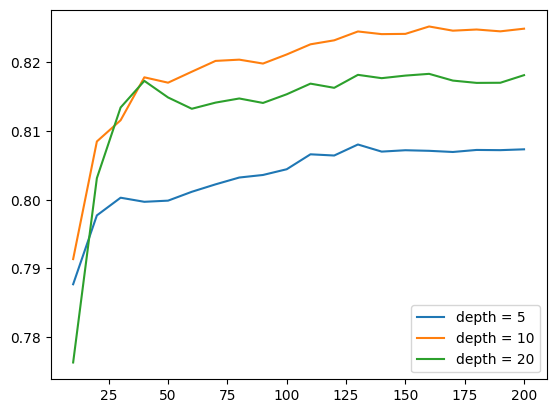

In [12]:
#parameter tuning for random forest

#max_depth
all_aucs = {}

for i in [5,10,20]:
    print('depth: %s' % i)
    aucs =[]

    for n in range(10,210,10):
        rt = RandomForestClassifier(n_estimators = n, random_state = 1, max_depth = i)
        rt.fit(X_train, y_train)
        y_pred = rt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        print(' %s -> %.3f' % (n, auc))
        aucs.append(auc)
    all_aucs[i] = aucs
    print()

num_trees = list(range(10, 201, 10))
plt.plot(num_trees, all_aucs[5], label = 'depth = 5')
plt.plot(num_trees, all_aucs[10], label = 'depth = 10')
plt.plot(num_trees, all_aucs[20], label = 'depth = 20')
plt.legend()

plt.show()

min_samples_leaf: 3
10 -> 0.925
30 -> 0.936
50 -> 0.939
70 -> 0.941
90 -> 0.942
110 -> 0.942
130 -> 0.943
150 -> 0.943
170 -> 0.943
190 -> 0.942

min_samples_leaf: 5
10 -> 0.909
30 -> 0.919
50 -> 0.920
70 -> 0.920
90 -> 0.922
110 -> 0.923
130 -> 0.923
150 -> 0.923
170 -> 0.923
190 -> 0.923

min_samples_leaf: 10
10 -> 0.886
30 -> 0.896
50 -> 0.896
70 -> 0.895
90 -> 0.895
110 -> 0.895
130 -> 0.896
150 -> 0.896
170 -> 0.895
190 -> 0.895



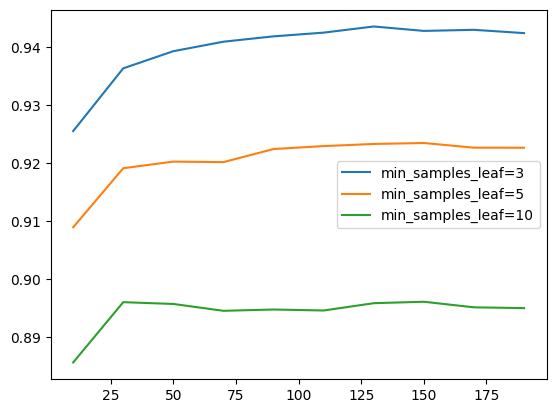

In [49]:
#min_samples_leaf
all_parameters = {}
all_aucs = {}
for m in [3, 5, 10]:
    print('min_samples_leaf: %s' % m)
    aucs = []
    for i in range(10, 201, 20):
        rf = RandomForestClassifier(n_estimators=i, max_depth=10, 
        min_samples_leaf=m, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (i, auc))
        aucs.append(auc)
        parameters = [m, i]
        all_parameters[auc] = parameters
    
    all_aucs[m] = aucs
    print()

num_trees = list(range(10, 201, 20))
plt.plot(num_trees, all_aucs[3], label='min_samples_leaf=3')
plt.plot(num_trees, all_aucs[5], label='min_samples_leaf=5')
plt.plot(num_trees, all_aucs[10], label='min_samples_leaf=10')
plt.legend()
plt.show()

In [51]:
all_parameters[max(list(all_parameters.keys()))]

[3, 130]

In [14]:
# the most optimal random forest model 
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=5, random_state=1)

In [15]:
#Gradient boosting

dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = dv.feature_names_)

dval = xgb.DMatrix(X_val, label = y_val, feature_names = dv.feature_names_)

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'silent': 1}


model = xgb.train(xgb_params, dtrain, num_boost_round= 10) # 10 is the number of trees to train

y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)    

[17:30:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



0.8152745150274878

In [16]:
#model performance monitoring

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'silent': 1
}

watchlist = [(dtrain, 'train'), (dval, 'val')]

model = xgb.train(xgb_params, dtrain, num_boost_round = 100, evals = watchlist, verbose_eval = 10) #verbose_eval indicates how often we print, aka after each 10th step.

#eta optimization

xgb_params = {
    'eta': 0.1, #decreased from 0.3 to 0.1 because the data isn't too large
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'silent': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round = 500, evals = watchlist, verbose_eval = 10)

#max_depth optimization

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'silent': 1
}

[17:30:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-auc:0.86300	val-auc:0.76818
[10]	train-auc:0.95002	val-auc:0.81558
[20]	train-auc:0.97316	val-auc:0.81775
[30]	train-auc:0.98772	val-auc:0.81787
[40]	train-auc:0.99456	val-auc:0.81387
[50]	train-auc:0.99688	val-auc:0.81128
[60]	train-auc:0.99889	val-auc:0.80801
[70]	train-auc:0.99944	val-auc:0.80732
[80]	train-auc:0.99985	val-auc:0.80677
[90]	train-auc:0.99992	val-auc:0.80637
[99]	train-auc:0.99998	val-auc:0.80546
[17:30:52] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-auc:0.86300	val-auc:0.76818
[10]	train-auc:0.91558	val-auc:0.80009
[20]	train-auc:0.93933	val-auc:0.80920
[30]	train-auc:0.95411	val-auc:0.81557
[40]	train-auc:0.96332	va

In [17]:
#apply the best model to our data

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)

df_train, df_val = train_test_split(df_train_full, test_size=0.25,random_state=11)

y_train = (df_train_full.status == 'default').values

y_test = (df_test.status == "default").values

del df_train_full['status']
del df_test['status']

dict_train = df_train_full.fillna(0).to_dict(orient = "records")
dict_test = df_test.fillna(0).to_dict(orient = "records")

dv = DictVectorizer(sparse = False)
X_train = dv.fit_transform(dict_train)
X_test = dv.transform(dict_test)

In [33]:
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = dv.feature_names_)
dtest = xgb.DMatrix(X_test, label = y_test, feature_names = dv.feature_names_)

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'silent': 1
}

num_trees = 160

model = xgb.train(xgb_params, dtrain, num_boost_round = num_trees)

y_pred_xgb = model.predict(dtest)
roc_auc_score(y_test, y_pred_xgb)

[19:04:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-030221e36e1a46bfb-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.



0.8322845901959826